In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
print(torch.__version__)
plt.ion()   # interactive mode

1.0.1


In [2]:
# import shutil
# import re
# files = os.listdir(r'C:\Users\Ajwl\Regression\dogCat\train')
# train_dir = r'C:\Users\Ajwl\Regression\dogCat\train'
# cat_train = r'C:\Users\Ajwl\Regression\dogCat\train\cat_train'
# dog_train = r'C:\Users\Ajwl\Regression\dogCat\train\dog_train'
# # Move all train cat images to cats folder, dog images to dogs folder
# for f in files:
#     catSearchObj = re.search("cat", f)
#     dogSearchObj = re.search("dog", f)
#     if catSearchObj:
#         shutil.move(f'{train_dir}/{f}', cat_train)
#     elif dogSearchObj:
#         shutil.move(f'{train_dir}/{f}', dog_train)

In [3]:
# validate_dog = r'C:\Users\Ajwl\Regression\dogCat\train\validate_dog'
# validate_cat = r'C:\Users\Ajwl\Regression\dogCat\train\validate_cat'
# cat_train = r'C:\Users\Ajwl\Regression\dogCat\train\cat_train'
# dog_train = r'C:\Users\Ajwl\Regression\dogCat\train\dog_train'

# files = os.listdir(dog_train)
# for f in files:
#     validationDogsSearchObj = re.search("5\d\d\d", f)
#     if validationDogsSearchObj:
#         shutil.move(f'{dog_train}/{f}', validate_dog)

# files = os.listdir(cat_train)
# for f in files:
#     validationDogsSearchObj = re.search("5\d\d\d", f)
#     if validationDogsSearchObj:
#         shutil.move(f'{cat_train}/{f}', validate_cat)

In [4]:
# normalize data to validation and training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5), # rotated train image 
        transforms.RandomHorizontalFlip(), # flip an image 
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),  # crop to dont missing small value
        transforms.ToTensor(), # convert image to npArray 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # best normalize value [mean..],[std...]
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 #in scale 0.96 if consider in bell curve that some data set are disregard

In [5]:
data_dir = r'C:\Users\Ajwl\Regression\dogCat'
SUBMISSION_FILE = r'C:\Users\Ajwl\Regression\dogCat\sampleSubmission.csv'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

cpu
['cat_train', 'dog_train', 'validate_cat', 'validate_dog']
Train image size: 313
Validation image size: 382


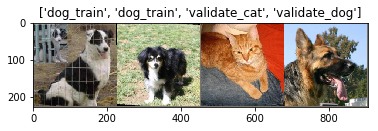

In [6]:
def imshow(inp, title=None):
    #Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.05)  # pause a bit so that plots are updated
inputs, classes = next(iter(dataloaders['train'])) # Get a batch of training data
sample_train_images = torchvision.utils.make_grid(inputs)  # Make a grid from batch
imshow(sample_train_images,title=[class_names[x] for x in classes]) 
#If we use classes directly it must be error in
#plot func. ==it not send str== so we need to get it from os libary

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_conv = torchvision.models.resnet50(pretrained=True)

In [9]:
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
for param in model_conv.parameters():
    param.requires_grad = True
model_conv = model_conv.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)


In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_conv = train_model(model_conv,criterion,optimizer_conv,exp_lr_scheduler,num_epochs = 3)

Epoch 0/2
----------
train Loss: 1.2801 Acc: 0.3738
val Loss: 2.4718 Acc: 0.1806

Epoch 1/2
----------
train Loss: 1.1017 Acc: 0.4696
val Loss: 3.5091 Acc: 0.0105

Epoch 2/2
----------
train Loss: 1.0695 Acc: 0.5495
val Loss: 3.9049 Acc: 0.0236

Training complete in 41m 15s
Best val Acc: 0.180628


NameError: name 'model_ft' is not defined

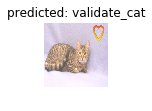

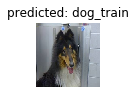

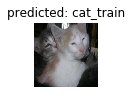

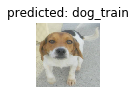

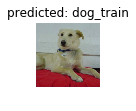

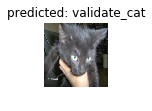

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()